In [1]:
from func import DataProcessor,TipFinder,VertexPos
import seaborn as sns
from plotly.offline import iplot,plot
import numpy as np
import pylab as plt
import pandas as pd
from scipy import stats
%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 20)


In [2]:
dp = DataProcessor('../../data/SQL/10C/85_8.db','../../data/SQL/10C/ProtoMap.db')

initialization will take some time
136.352702856
   PadNum        PadName     PadX      PadY  BinNum
0       0  sector_center  0.00000  0.000000     257
1       1      sector1_0  1.30108  0.947523       1
2       2      sector2_0  2.18496  1.831410       2
3       3      sector1_1  2.71529  2.361740       3
4       4      sector2_1  3.59917  3.245620       4
loading finished
begin processing
13.9376211166
33.3734431267
processing finished


In [3]:
def AveDist(x,y,k,b):
    return np.sum(np.abs(k*x+b-y)/(k*k+1))/x.shape[0]

def r2(x,y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    return r_value*r_value

def DoIt(fits,pic,y0):
    pic = np.copy(pic)    
    if sum([f[0]>60 for f in fits]) == 0: raise Exception('This is probably an unreacted beam')
    
    max_idx = max(zip(range(4),fits),key=lambda x:x[1][0])[0]
    opp_idx = (max_idx+2)%4
    #print max_idx, opp_idx

    k1,b1 = fits[max_idx][1:3]
    if fits[opp_idx][0]>50:
        k2,b2 = fits[opp_idx][1:3]
        return (b2-b1)/(k1-k2), (k2*b1-k1*b2)/(k2-k1)
    else:
        x0 = (y0-b1)/k1
        pic[:,:int(x0)+5]=0
        yy,xx = np.where(pic)
        
        k2,b2 = np.polyfit(xx,yy,1)
        if r2(xx,yy)>0.5: 
            return (b2-b1)/(k1-k2), (k2*b1-k1*b2)/(k2-k1)
        else:
            return x0,y0

def Process(pic,images):
    pic_ = np.copy(pic)

    #score,y0,y1 = VertexPos(pic_)
    points = TipFinder(pic_)
    xv,yv = points[points[:,0].argsort()][-1]
    
    #### get fit from each of the quadrant ###
    width = 20
    thre = 80
    fits = []
    for idx,image in enumerate(images):
        image = np.copy(image)
        image[int(yv)-width:int(yv)+width,:] = 0
        if np.sum(image>10) > 60:
            ys,xs = np.where(image)

            try:
                k,b = np.polyfit(xs,ys,1)
                if r2(xs,ys)>0.8:
                    fits.append((np.sum(image>10),k,b,r2(xs,ys)))
                else:
                    fits.append((0,0,0,100))
            except:
                fits.append((0,0,0,100))

        else:
            fits.append((0,0,0,100))
    
    if abs(yv-150)>50: raise Exception('off center error')
    ### process the fits according to each of the scenario
    print fits
    xc,yc = DoIt(fits,pic,yv)
    
    return xv,yv,xc,yc

In [38]:

distance = []

for EID in dp.t3['EventID'].unique():
    
    pic, images = dp.Process1(EID)
    #plt.clf()
    #sns.heatmap(pic[::-1], xticklabels=30, yticklabels=30)
    try:
        
        xv,yv,xc,yc = Process(pic, images)
        #plt.scatter([xc],[yc])
        dist = ((xc-xv)**2+(yc-yv)**2)**0.5
        distance.append({'EID':EID,'dist':dist})
        print EID,dist
    except:
        pass

25 119.694802525
78 90.3353477313
92 12.3643117249
456 103.413355656
978 113.776955735
998 134.085115958
1008 3.18840804224
1097 143.570422913
1104 1.36705934257
1309 195.582793848
1385 169.514081239
1730 140.238524098
1762 3.50499675732
1911 75.1199100778
1918 265.798044072
543 10.9990607763
1084 34.8044556605
1783 207.984492249
1690 30.8314731638
293 8.37571388222
46 4.14360926947
1129 72.4914212344
1778 32.3506665477
417 42.1556159243
752 184.928657188
385 136.468888997
1603 5.48785371568
1096 102.035362742
173 237.330821758
1818 92.7113262357
1829 45.2872323118
76 66.657250426
783 16.8319430192
721 100.915588125
883 106.940637515
881 79.1375304654
1162 110.589915825
267 182.895307573
445 244.75044224
104 91.7133138039
115 71.873216974
985 59.2304222887
1481 337.01701338
932 67.1001443121
1903 20.6729818927
1834 40.2650969395
40 43.4755787135
1878 51.1564794555
1207 38.6915008797
1327 26.2695305428
989 127.293548175
1367 55.2214822846
1175 56.9334590033
13 29.0374950409
152 99.17755

/afs/crc.nd.edu/user/j/jlai1/.local/usr/share/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:25: RankWarning:

Polyfit may be poorly conditioned



1803 33.3447216021
187 61.4072429944
277 80.7387266194
480 15.4558704769
660 31.6281540317
786 53.5003855984
616 91.8434112747
1053 153.728288269
1107 85.0743931264
924 61.4725290002
1732 53.0984600423
603 82.0111778462
866 66.4211807744
562 199.317415104
663 118.110785677
756 12.3619902739
648 173.262603394
360 134.508953413
804 79.2262326303
1062 7.17873967147
334 18.1720632572
535 144.148795474
999 104.341481834
1507 194.422826755
1863 35.0253403448
872 119.596292484
1209 88.8431059015
1293 23.7415286632
874 71.4902081377
1810 95.0520563451
1830 96.1715051583
1121 154.206143713
1363 78.6945684279
987 91.1539717309
47 211.585802759
241 110.845484065
537 97.3169400626
1613 131.312948516
235 91.6210888045
1285 135.377169117
1461 128.893939356
1513 6.30515934656
1780 117.619527692
1027 124.443918161
1734 130.838137883
1173 82.4244212439
212 55.7324905219
1092 129.37371964
1206 98.2614195814
1629 6.61671712368
1719 116.525079597
585 111.627094209
1201 51.4931791939
1362 113.99848538
1535

/afs/crc.nd.edu/user/j/jlai1/.local/usr/share/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:25: RankWarning:

Polyfit may be poorly conditioned



1223 4.92592334657
1283 81.2593960073
1459 77.0039336735
1751 233.468635576
223 113.443128882
782 68.4181945469
1035 89.2223677677
157 179.776062227
353 134.8389566
424 81.8008566978
735 14.8695516163
916 95.4612574658
1024 81.4438107381
1132 138.665309728
1431 139.039229354
1634 86.4527260833
23 7.21468314496
63 31.9121891729
867 73.2041573475
1305 57.6952918661
1725 179.0
308 16.4771491607
518 100.065251905
655 29.463094483
1458 42.1719127428
280 12.1315157701
412 63.8155405384
629 41.9533648184
1425 10.0194159242
1511 95.2302382911
1796 31.6486548582
185 87.2605107395
409 94.0359904169
522 59.34574831
555 86.0774887147
636 93.3786414352
739 96.4039672621
997 167.899715304
1032 85.8165187386
1524 77.7760848756
408 81.0059303384
492 91.8721763891
634 127.609451523
1504 89.4156160547
1864 94.635446075
612 110.327808346
734 178.943705029
736 104.89049493
837 24.5636436302
977 29.4898075394
1034 93.2644395458
1110 6.37781528615
1417 177.512536027
1484 63.6949703124
1760 6.92094170634
2 4

974 35.2830260695
1412 15.6914906277
1423 32.4322578893
1424 14.2868303582
1770 36.9112696631
591 173.859052096
650 45.6600639578
1045 156.802511774
1066 56.3593256951
1139 8.67399425618
1282 80.2693501117
1769 43.701806218
3 35.7391494349
51 104.301487876
894 37.632654411
1152 28.6672797483
1618 9.12677782587
1694 25.2490696143
1850 47.6519814657
127 20.6004058539
336 65.8684736111
818 14.9725619433
854 20.568249367
1545 32.7519750423
1573 44.9025174743
1763 41.827673058
328 33.1258391126
1158 105.729870239
1177 37.2411258764
1219 34.0839526945
1917 35.4641949498
116 54.5374246043
370 37.736795021
465 21.3155026185
819 21.0448424879
1276 22.9197852941
1418 25.0194459538
141 39.8044205793
472 30.7269296453
689 23.227953881
850 49.7199905567
885 23.6082681797
1047 31.6042034164
1116 266.049030155
1156 19.5840575899
68 128.741734085
533 19.1428400975
1046 11.1867439727
1547 36.7285655713
1569 15.5268030415
282 40.1641682498
351 10.7791397621
476 32.8945881483
869 16.3659199128
1124 14.44

/afs/crc.nd.edu/user/j/jlai1/.local/usr/share/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:25: RankWarning:

Polyfit may be poorly conditioned



1620 203.734947589
44 18.2023926392
252 116.845456511
341 20.4560133445
570 139.014048743
628 131.746326848
1113 9.75279321136
1242 7.10573424265
1312 17.4916915896
1646 27.2014476049
1784 51.6184623273
271 6.9366016221
519 28.3150649296
705 14.0032001541
945 126.295427514
1826 143.170916475
85 159.362615283
111 28.7864174489
800 81.67792641
1001 23.6525051431
1426 36.4807748596
1794 23.6722677223
1823 38.2921979594
307 19.8081724507
311 22.5966368233
453 68.7430882206
656 3.87530463683
765 142.57400953
796 62.0696283
1230 53.80294844
1713 94.7337096413
218 23.454115368
873 129.642840182
947 21.0827669064
1220 25.5930701835
1350 44.3930216363
1752 11.1031363175
1814 133.537954013
419 24.0541433148
513 9.01792352934
690 32.6899027786
935 20.6907558309
1072 27.3255247696
1251 94.6976697315
229 66.3662874845
339 33.9619321907
382 22.2216065083
621 27.2454250335
737 10.8203768345
958 5.6776135064
1273 95.2066524328
1345 9.50842204306
329 19.5438241772
1390 10.2338630116
1447 6.49312441903


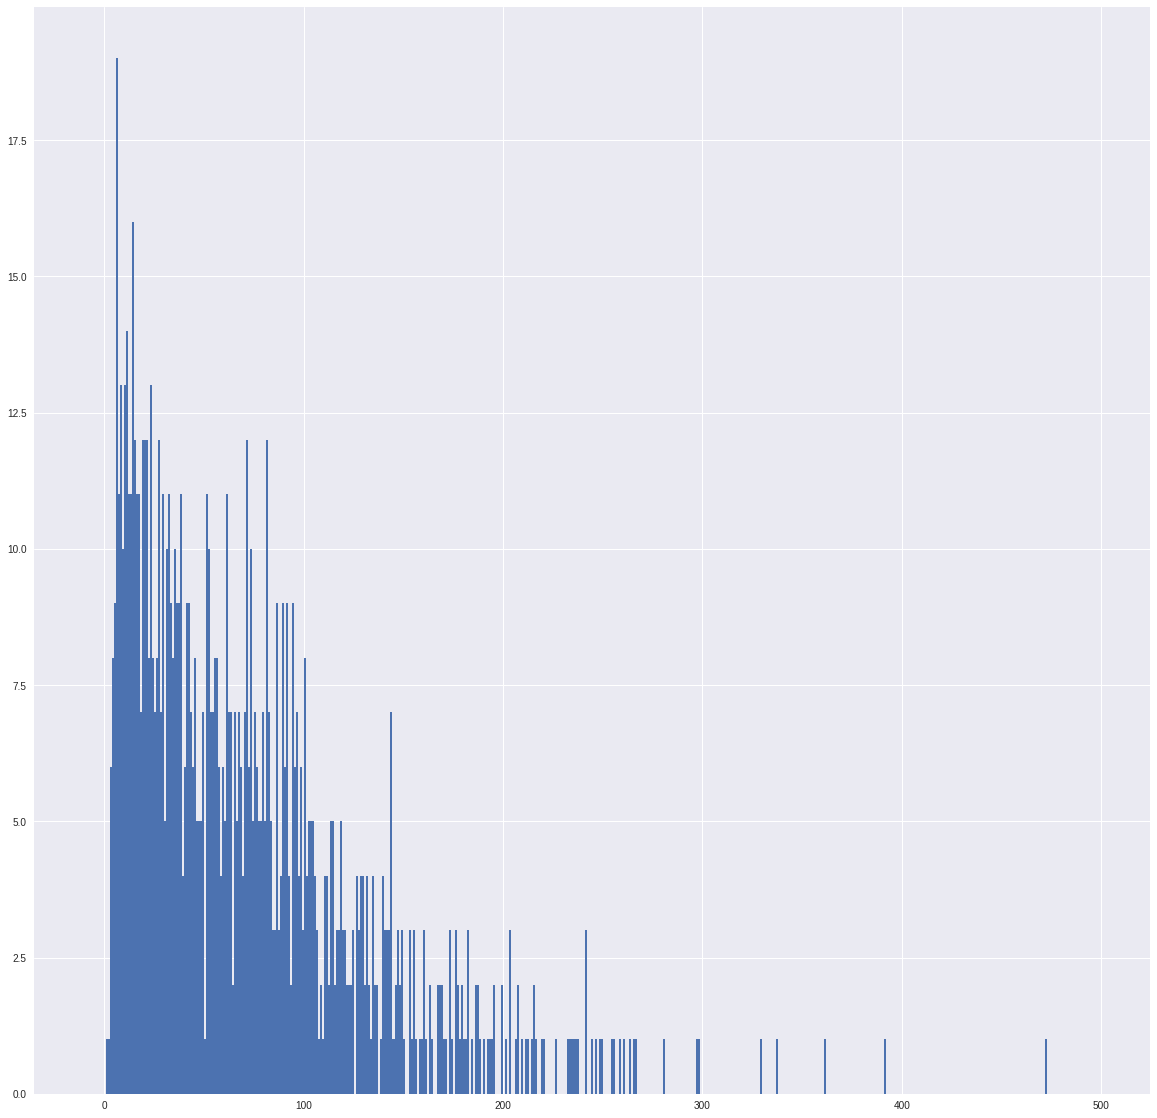

In [39]:
plt.hist([one['dist'] for one in distance],bins=np.arange(-10,500,1));

In [40]:
[one['EID'] for one in distance if one['dist']>300]

[1481, 1779, 427, 683, 838, 1093, 719]

[(0, 0, 0, 100), (0, 0, 0, 100), (225, 1.6887195956162955, -141.49719840435449, 0.90631769517466976), (0, 0, 0, 100)]
174.98298662 154
337.01701338


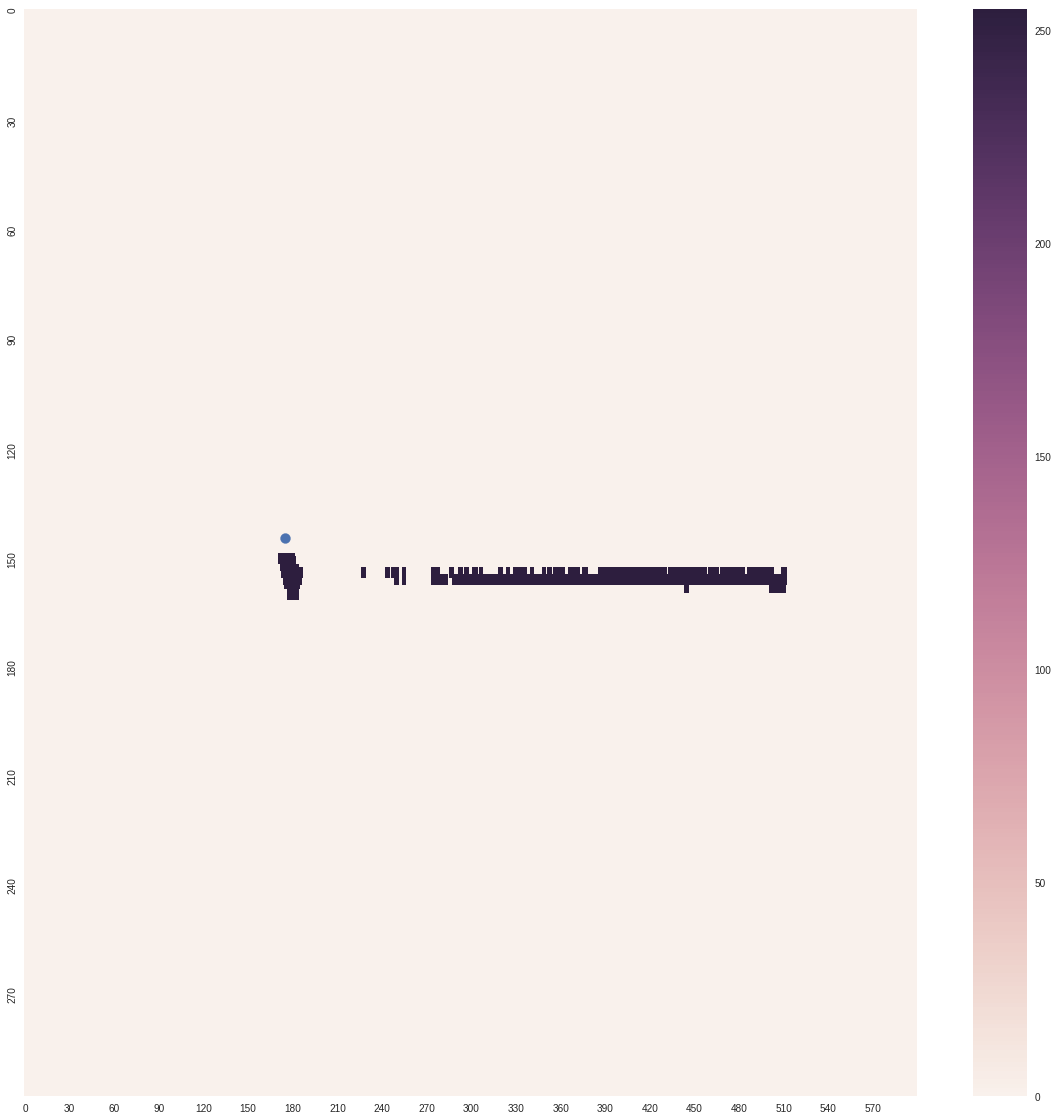

In [9]:
pic, images = dp.Process1(1481)
sns.heatmap(pic, xticklabels=30, yticklabels=30)
xv,yv,xc,yc = Process(pic, images)
plt.scatter([xc],[yc],s=100)
dist = ((xc-xv)**2+(yc-yv)**2)**0.5

print xc,yc
print dist



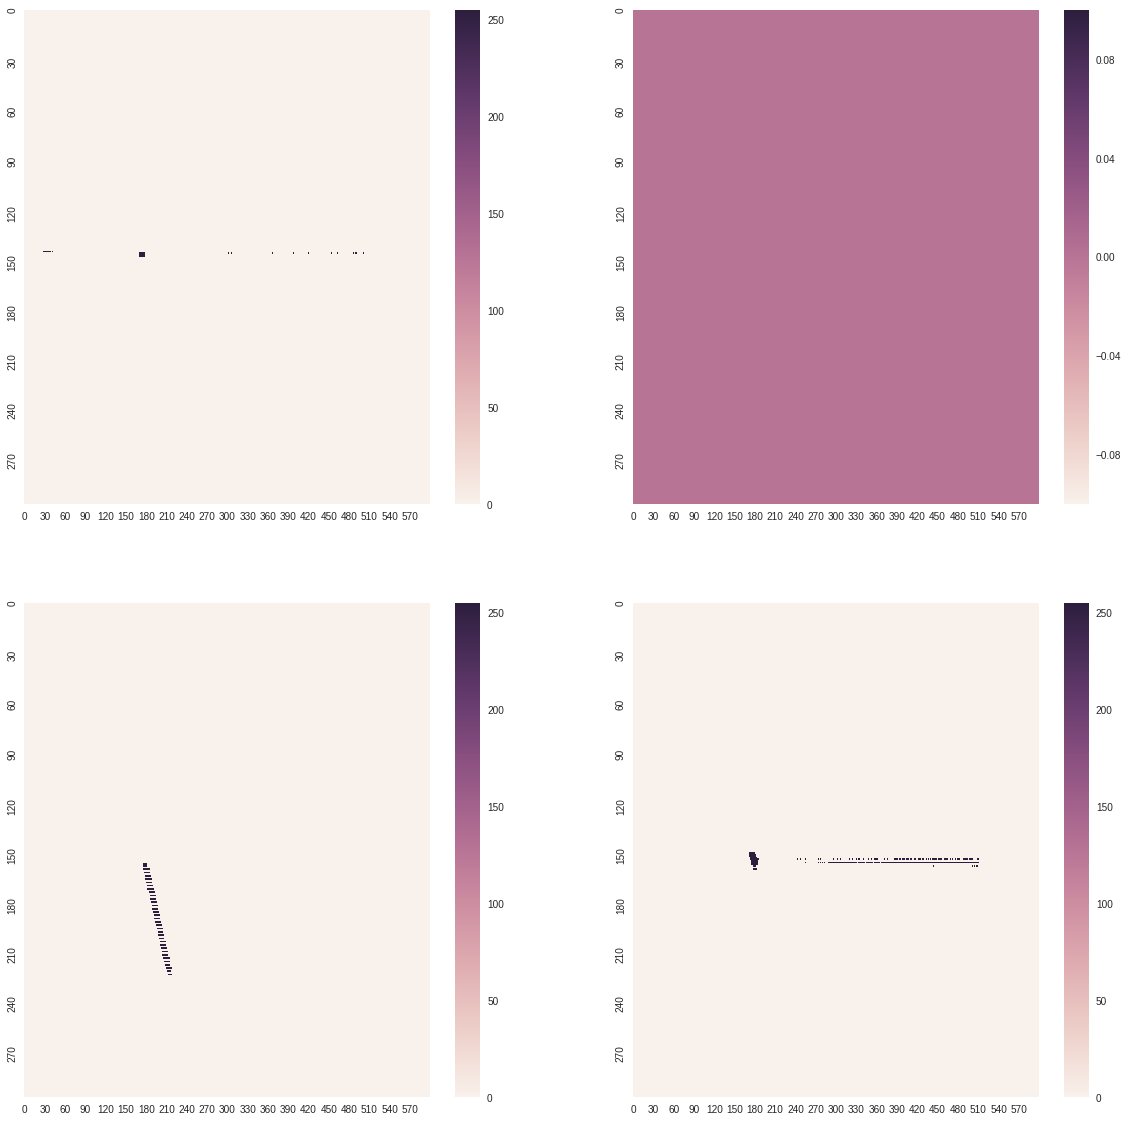

In [8]:
for i in range(4):
    plt.subplot(2,2,i+1)
    sns.heatmap(images[i], xticklabels=30, yticklabels=30)

